## Module 3.3: VAEs for Synthetic Data Generation

We will create a variational auto-encoder that we will use to generate synthetic images.

We will:
- Implement the VAE architecture in Keras.
- Train our model.
- Use our model to generate synthetic data based on the dataset in general.
- Use our model to generate synthetic data similar to particular data cases.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

We import required libraries.

In [1]:
import numpy as np
import numpy.random as rng

import matplotlib.pyplot as plt

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.backend import random_normal

We will again be working with the MNIST data. These are 28x28 greyscale images of handwritten digits (0-9). The classes are the digit.

This time we will be working with the input data as vectors, but still need to normalize the pixel values to real numbers between 0 and 1. Below we create a function that will do this, then call it.

If you want to look at the data, examine the code in module 2.4, as this provides functions for viewing the MNIST images with their class labels.

In [2]:
def get_data():
  # Load the MNIST digits
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  # Pre-process them into real numbers between 0 and 1 and flatten
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
  return x_train,y_train,x_test,y_test

In [3]:
x_train,y_train,x_test,y_test=get_data()

Now we will create a function that defines, creates and compiles our VAE model. 

We will encode our data in a 2d Gaussian with independent variance. This means we have four parameters - 2 mean parameters and 2 standard deviation parameters. We will specify the prior to be a 2d standard normal distribution (i.e. with independent variance/standard deviation of 1).

We will use the Kullback-Leibler divergence as the distribution loss. This is a measure of divergence of one distribution from another (from the perspective of the second - read up online to learn more), and we will use it to penalize encodings that diverge too far from the standard normal. This will enable us to generate synthetic data via samples from the 2d standard normal later.

For ease of use, we will return five models: 
- A distributional encoder, that encodes an image as a distribution.
- A probablistic encoder, that encodes the image as a vector sampled *from* the encoded distribution.
- A decoder that reconstructs the image from the encoded distribution.
- A decoder that reconstructs the images from a sample *from* the encoded distribution
- The complete VAE. 

The comments in the code include more information, so read over them as you proceed.

In [13]:
# We pass dimensions and optimizer as arguments so code can be reused 
# with freedom. However note that we want a latent dimension of 2 
# in order to give 2d plots later, and need the input dimension to be
# 784 to work with Mnist digit images.
def get_vae (
    latent_dim=2,
    intermediate_dim=256,
    input_dim=784, # Mnist digit size
    optimizer= Adam(lr = 0.001)
):    
    # Create the encoding layers
    # Our encoder will have a single hidden layer, leading to the mean and variance layers.
    encoder_input = Input((input_dim,))
    encoder_hidden = Dense(intermediate_dim, 
                           activation='relu')(encoder_input)
    encoder_mean = Dense(latent_dim)(encoder_hidden)
    encoder_log_var = Dense(latent_dim)(encoder_hidden)

    # We want to include a component of our loss function that penalizes
    # the encoding distribution for its KL-divergence from our chosen prior.
    # This can be done with the following custom layer:
    class KLDivergenceLayer(Layer):
        """ 
        Identity transform layer that adds KL divergence
        to the final model loss.
        """
        def __init__(self, *args, **kwargs):
            self.is_placeholder = True
            super(KLDivergenceLayer, self).__init__(*args, **kwargs)

        def call(self, inputs):
            mean, log_var = inputs
            # We calculate the KL divergence from our chosen 
            # prior (2-d standard normal).            
            kl_loss = - .5 * K.sum(1 + log_var -
                                    K.square(mean) -
                                    K.exp(log_var), axis=-1)
            # The add_loss function means that this will be added
            # to the final model loss when a model with this layer
            # is compiled.
            self.add_loss(K.mean(kl_loss), inputs=inputs)
            # We return the inputs unchanged.
            return inputs
        
    # We add our custom KLDivergenceLayer to the model.
    encoder_mean2, encoder_log_var2 = KLDivergenceLayer()(
        [encoder_mean, encoder_log_var])
    
    # To begin the decoding component we want to sample from the 
    # latent distribution generated by the variational encoder.
    # We define a function that can do this to use in a Lambda layer.
    def sampling(args):
        z_mean, z_log_var = args
        epsilon_std = 1.0
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    # And we add the lambda layer to the model graph
    sampled = Lambda(sampling)([encoder_mean2,encoder_log_var2])    

    # We instantiate these layers separately so as to reuse them later
    # (Not so important to do the sampling layer, since it has no weights)
    decoder_hidden_layer = Dense(intermediate_dim, activation='relu')
    decoder_output_layer = Dense(input_dim, activation='sigmoid')
    # And now use them to continue the vae model graph
    decoder_hidden = decoder_hidden_layer(sampled)
    decoder_output = decoder_output_layer(decoder_hidden)

    # Now we can define our full VAE
    vae = Model(encoder_input, decoder_output)
    
    # We have the KL-divergence loss specified inside the KLD layer. But we
    # need a reconstruction loss. We will use negative log likelihood (and there
    # are good theoretical reasons for this), but need to wrap it as so:
    def nll(y_true, y_pred):
        # keras.losses.binary_crossentropy gives the mean
        # over the last axis. we require the sum
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Now we compile the variational auto-encoder.
    vae.compile(optimizer=optimizer, loss=nll)
    
    # For ease, we will also specify encoder and decoder sub-models.
    # First we specify the variational encoder, that encodes the input
    # as a distribution.
    latent_mean = encoder_mean # reference added for completness otherwise produce errors
    latent_log_var = encoder_log_var # reference added for completness otherwise produce errors
    dist_encoder = Model(encoder_input,[latent_mean,latent_log_var])
    # Then we specify a probabilistic encoder. This will 
    # probabilisitcally project inputs on the latent space - ie
    # it gives a probabilistic encoding (not a distribution, but a 
    # sample from the distribution)
    encoder = Model(encoder_input, sampled)
    
    # Now we build a digit generator that can sample from the learned 
    # distribution. Note we use the same layers, so when they are
    # trained while training the VAE, the stand alone decoder will
    # be trained as well.
    decoder_point_input = Input(shape=(latent_dim,))
    decoder_hidden_b = decoder_hidden_layer(decoder_point_input)
    decoder_output_b = decoder_output_layer(decoder_hidden_b)
    generator = Model(decoder_point_input, decoder_output_b)
    
    # We will also want to generate synthetic based on 
    # posteriors from known images. In this case the generated 
    # images will be similar to the image that generated the posterior 
    # (the posterior will be generated from the image via the encoder).
    decoder_dist_mean_input = Input(shape=(latent_dim,))
    decoder_dist_log_var_input = Input(shape=(latent_dim,))
    decoder_sampled = Lambda(sampling)([decoder_dist_mean_input,decoder_dist_log_var_input])    
    decoder_hidden_d = decoder_hidden_layer(decoder_sampled)
    decoder_output_d = decoder_output_layer(decoder_hidden_d)
    post_generator = Model([decoder_dist_mean_input,decoder_dist_log_var_input], decoder_output_d)
        
    # Return our models
    return vae,encoder,dist_encoder,generator,post_generator

We call the above function and get our models.

In [14]:
vae,encoder,dist_encoder,generator,post_generator=get_vae()

Now we create function to train the model - it is just a wrapper for the Keras train function. We will perform early stopping with patience 10 and use the test data as validation data. Remember, since this is an auto-encoder the target variables are just the input variables.

In [16]:
def train(
  vae,
  x_train,
  x_test,
  batch_size = 100,
  epochs = 200
):
  early_stopping=EarlyStopping(
      monitor='val_loss', 
      patience=10, 
      verbose=2,
      restore_best_weights=True
  )
  # We need to train the variational auto-encoder before anything else!
  train_history=vae.fit(
      x_train,
      x_train,
      shuffle=True,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(x_test, x_test),
      callbacks=[early_stopping]
  )
  return train_history

Now we train our model. You can graph the training history as an exercise if you wish.

In [17]:
train_history=train(vae,x_train,x_test)

Epoch 1/200
600/600 [==============================] - 2s 3ms/step - loss: 199.5722 - val_loss: 172.8897
Epoch 2/200
600/600 [==============================] - 1s 2ms/step - loss: 169.7136 - val_loss: 167.4540
Epoch 3/200
600/600 [==============================] - 1s 2ms/step - loss: 165.8795 - val_loss: 164.9090
Epoch 4/200
600/600 [==============================] - 1s 2ms/step - loss: 163.6830 - val_loss: 163.1102
Epoch 5/200
600/600 [==============================] - 1s 2ms/step - loss: 162.1107 - val_loss: 161.8143
Epoch 6/200
600/600 [==============================] - 1s 2ms/step - loss: 160.7557 - val_loss: 160.4270
Epoch 7/200
600/600 [==============================] - 1s 2ms/step - loss: 159.5770 - val_loss: 159.4859
Epoch 8/200
600/600 [==============================] - 1s 2ms/step - loss: 158.5196 - val_loss: 158.7466
Epoch 9/200
600/600 [==============================] - 1s 2ms/step - loss: 157.5742 - val_loss: 157.6717
Epoch 10/200
600/600 [==============================] -

Let's create and then call a function that will graph the probabilistic encodings of the test images (remember these are the vector encodings sampled from the distributional encodings for each image). We would like to see good clusters for the different classes.

In [18]:
def display_embeddings(
    encoder,
    test_x,
    test_y,
    batch_size
):
    # display a 2D plot of the digit classes in the encoding space
    x_test_encoded = encoder.predict(test_x, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=test_y)
    plt.colorbar()
    plt.show()

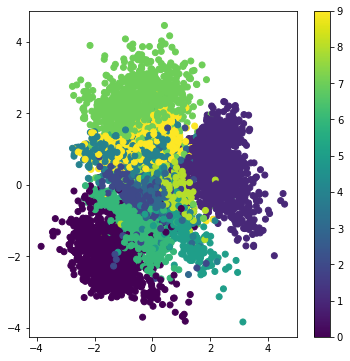

In [19]:
display_embeddings(encoder,x_test,y_test,100)

Now let's have a look at the images reconstructed from different points in our prior. (Remember we will be sampling from the prior to generate different synthetic images - so we would like to see different images clustered at different locations). We can generate these images by picking a grid of points within the high-probability region of the 2d standard normal and passing these to the (vector) decoder for reconstruction.

In [20]:
# We pass image dimensions as arguments so code can be reused with
# more freedom. However note that we need 28 by 28 to work with 
# Mnist digit images.
def display_distribution_images (
    generator,
    image_width = 28,
    image_height = 28
):
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    figure = np.zeros((image_width * n, image_height * n))
    # linearly spaced coordinates on the unit square were transformed 
    # through the inverse CDF (ppf) of the Gaussian to produce values 
    # of the latent variables z, since the prior of the latent space is 
    # Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            latent_sample = np.array([[xi, yi]])
            decoded = generator.predict(latent_sample)
            digit = decoded[0].reshape(image_width, image_height)
            figure[i * image_width: (i + 1) * image_width,
                   j * image_height: (j + 1) * image_height] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Let's have a look at the images generated at different poins in the prior distribution. You can see that similar digits struggle to be differentiated (3 & 8, 4 & 9), but it is pretty impressive for our quick attempt. It may be that having a larger latent dimension would help this. 

(1, 2)
[[-1.64485363 -1.64485363]]
(1, 2)
[[-1.20404696 -1.64485363]]
(1, 2)
[[-0.92082298 -1.64485363]]
(1, 2)
[[-0.69714143 -1.64485363]]
(1, 2)
[[-0.50396537 -1.64485363]]
(1, 2)
[[-0.32807211 -1.64485363]]
(1, 2)
[[-0.16184417 -1.64485363]]
(1, 2)
[[-1.39145821e-16 -1.64485363e+00]]
(1, 2)
[[ 0.16184417 -1.64485363]]
(1, 2)
[[ 0.32807211 -1.64485363]]
(1, 2)
[[ 0.50396537 -1.64485363]]
(1, 2)
[[ 0.69714143 -1.64485363]]
(1, 2)
[[ 0.92082298 -1.64485363]]
(1, 2)
[[ 1.20404696 -1.64485363]]
(1, 2)
[[ 1.64485363 -1.64485363]]
(1, 2)
[[-1.64485363 -1.20404696]]
(1, 2)
[[-1.20404696 -1.20404696]]
(1, 2)
[[-0.92082298 -1.20404696]]
(1, 2)
[[-0.69714143 -1.20404696]]
(1, 2)
[[-0.50396537 -1.20404696]]
(1, 2)
[[-0.32807211 -1.20404696]]
(1, 2)
[[-0.16184417 -1.20404696]]
(1, 2)
[[-1.39145821e-16 -1.20404696e+00]]
(1, 2)
[[ 0.16184417 -1.20404696]]
(1, 2)
[[ 0.32807211 -1.20404696]]
(1, 2)
[[ 0.50396537 -1.20404696]]
(1, 2)
[[ 0.69714143 -1.20404696]]
(1, 2)
[[ 0.92082298 -1.20404696]]
(1, 

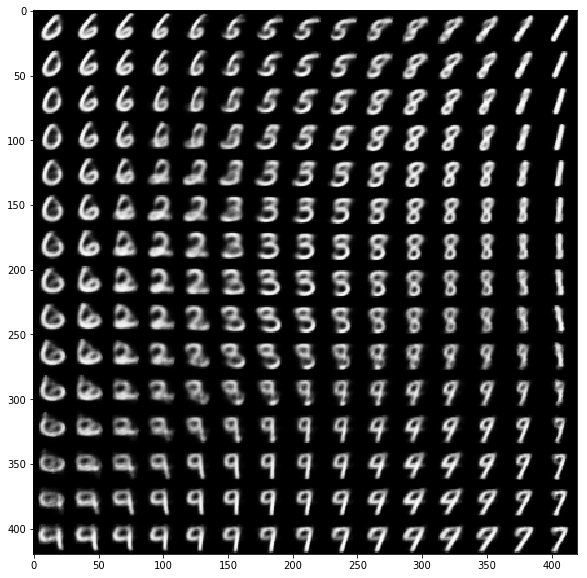

In [0]:
display_distribution_images(generator)

Now let's see what happens when we generate 100 random images from the prior.

In [21]:
# We pass image dimensions as arguments so code can be reused with
# more freedom. However note that we need 28 by 28 to work with 
# Mnist digit images.

# Display a 2D set of synthetic digits of size n x n.
def generate_synthetic_data (
    generator,
    mean=np.array([0,0]),
    log_var=np.array([0,0]),
    n=10
):    
    # Note the Mnist image dimension is hardcoded here.
    image_dim=28
    
    # Transform log variance to standard deviation
    std_dev=np.exp(.5*log_var)
    figure = np.zeros((image_dim * n, image_dim * n))
 
    for i in range(n):
        for j in range(n):
            latent_sample=np.array([[rng.normal(mean[i],std_dev[i]) for 
                                    i in range(2)]])
            decoded = generator.predict(latent_sample)
            digit = decoded[0].reshape(image_dim, image_dim)
            figure[i * image_dim: (i + 1) * image_dim,
                   j * image_dim: (j + 1) * image_dim] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

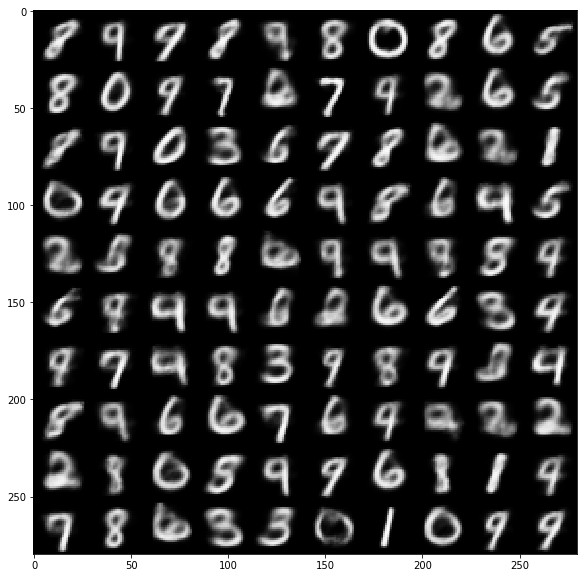

In [0]:
generate_synthetic_data(generator)

Finally let's generate synthetic data that is like some particular labelled image.

In [22]:
def generate_synthetic_data_from_image(
    dist_encoder,
    generator,
    image,
    n=10
):
    mean,log_var=dist_encoder.predict(image)
    generate_synthetic_data(generator,mean[0],log_var[0],n)

def find_sample_image(
    image_set, # The image set (e.g. x_test)
    classes, # The labels for the image set
    digit, # The class you want
    rand=True # If False the first example of the class is chosen
):
    instances=np.where(classes==digit)[0]
    if rand:
        instance=rng.choice(instances,1)
    else:
        instance=instances[0]
    return image_set[instance,:]
    

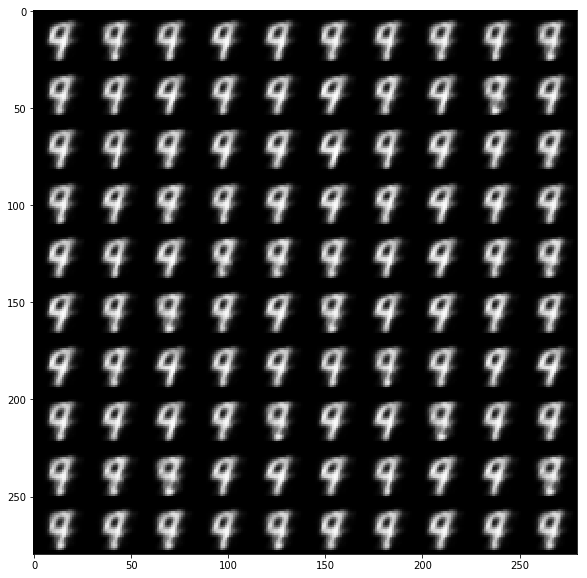

In [0]:
image=find_sample_image(x_test,y_test,4)
generate_synthetic_data_from_image(dist_encoder,
    generator,
    image)